# Imports

In [ ]:
!pip install category_encoders

In [373]:
import pandas as pd
import optuna
import numpy as np
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [374]:
df = pd.read_csv('y_posts.csv')

# EDA

In [375]:
df.describe()

,UserID,PostID,Age,Followers,PostHour,Likes,Shares,Comments,EngagementScore
count,5000.0000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,503.7098,2499.500000,34.01800,205.586600,11.762000,28.977600,4.965400,15.295200,1.547303
std,288.4307,1443.520003,9.59565,203.580275,6.937505,27.176946,2.245353,21.652303,4.254233
min,0.0000,0.000000,18.00000,2.000000,0.000000,7.000000,0.000000,0.000000,0.017450
25%,252.0000,1249.750000,25.00000,61.000000,6.000000,17.000000,3.000000,2.000000,0.181470
50%,502.0000,2499.500000,34.00000,149.000000,12.000000,20.500000,5.000000,4.000000,0.440183
75%,756.0000,3749.250000,43.00000,277.250000,18.000000,24.000000,6.000000,8.000000,1.233675
max,999.0000,4999.000000,49.00000,1490.000000,23.000000,177.000000,17.000000,61.000000,121.000000


In [376]:
df.UserID.value_counts()

UserID
725    15
438    13
924    12
72     12
757    12
       ..
815     1
173     1
822     1
580     1
774     1
Name: count, Length: 989, dtype: int64

In [377]:
df.PostID.value_counts

<bound method IndexOpsMixin.value_counts of 0          0
1          1
2          2
3          3
4          4
        ... 
4995    4995
4996    4996
4997    4997
4998    4998
4999    4999
Name: PostID, Length: 5000, dtype: int64>

In [378]:
pd.DataFrame(df.dtypes,columns=['Type'])

,Type
UserID,int64
PostID,int64
Age,int64
Country,object
Followers,int64
PostType,object
PostHour,int64
PostWeekday,object
Likes,int64
Shares,int64


In [379]:
df['PostType'].value_counts()

PostType
Text     2025
Image    1552
Video    1423
Name: count, dtype: int64

In [380]:
df['Country'].value_counts()

Country
USA       1096
Spain     1052
France    1036
Canada     928
UK         888
Name: count, dtype: int64

<Axes: >

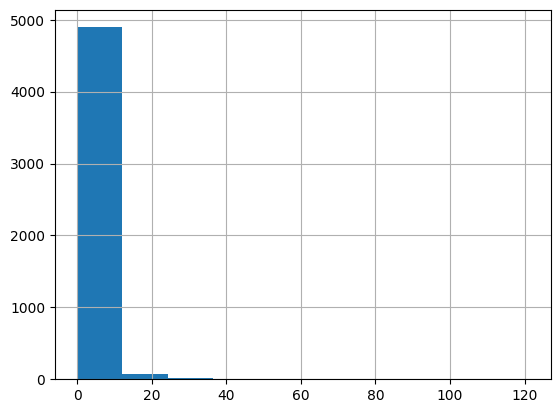

In [381]:
df['EngagementScore'].hist()

In [382]:
grouped = df.groupby('UserID')['EngagementScore'].agg(['mean', 'median', 'min', 'max', 'std', 'count'])

/home/vhodlevskyi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


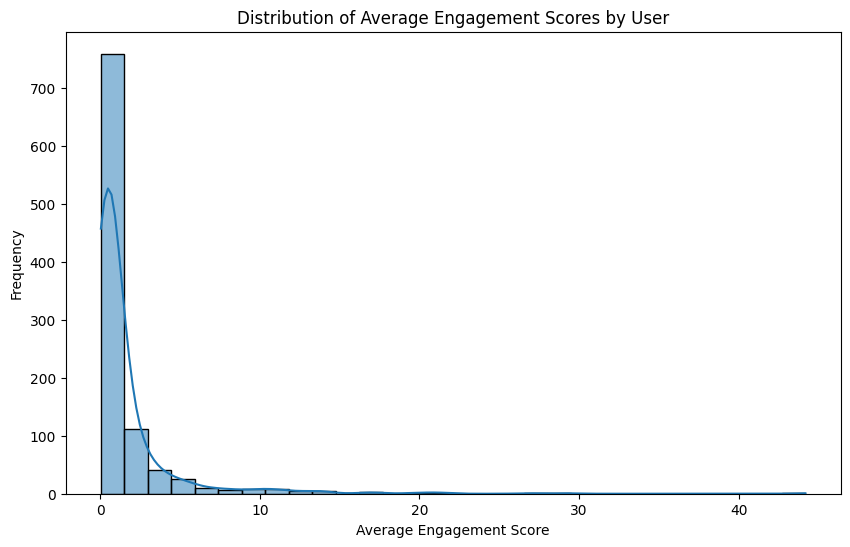

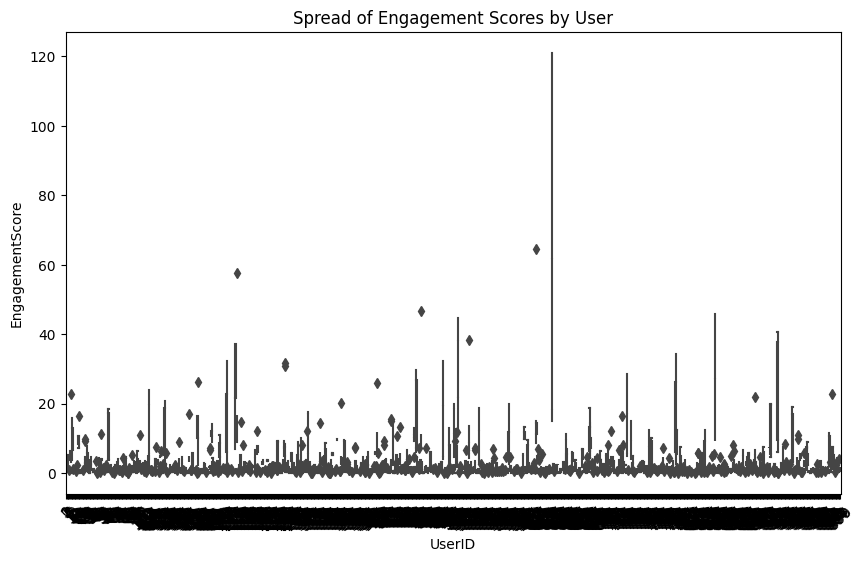

In [383]:
plt.figure(figsize=(10, 6))
sns.histplot(grouped['mean'], bins=30, kde=True)
plt.title('Distribution of Average Engagement Scores by User')
plt.xlabel('Average Engagement Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='UserID', y='EngagementScore')
plt.title('Spread of Engagement Scores by User')
plt.xticks(rotation=45)
plt.show()

In [356]:
max_UserID = df[df.EngagementScore == max(df.EngagementScore)].UserID.item()

In [357]:
df[df.UserID == max_UserID]

,UserID,PostID,Age,Country,Followers,PostType,PostHour,PostWeekday,Likes,Shares,Comments,EngagementScore
220,627,220,47,USA,2,Text,4,Wednesday,19,5,3,18.5
1098,627,1098,47,USA,2,Text,7,Thursday,22,6,1,17.0
1142,627,1142,47,USA,2,Video,12,Saturday,20,4,5,19.0
1182,627,1182,47,USA,2,Text,21,Monday,79,6,4,53.0
2347,627,2347,47,USA,2,Video,3,Sunday,21,1,2,15.0
2673,627,2673,47,USA,2,Text,12,Sunday,18,5,5,21.0
2872,627,2872,47,USA,2,Video,22,Monday,75,6,53,121.0
4653,627,4653,47,USA,2,Image,9,Friday,13,7,52,89.0


In [ ]:
scores_by_user = [group['EngagementScore'].values for name, group in df.groupby('UserID')]

anova_result = f_oneway(*scores_by_user)
print(f"ANOVA result: Statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")

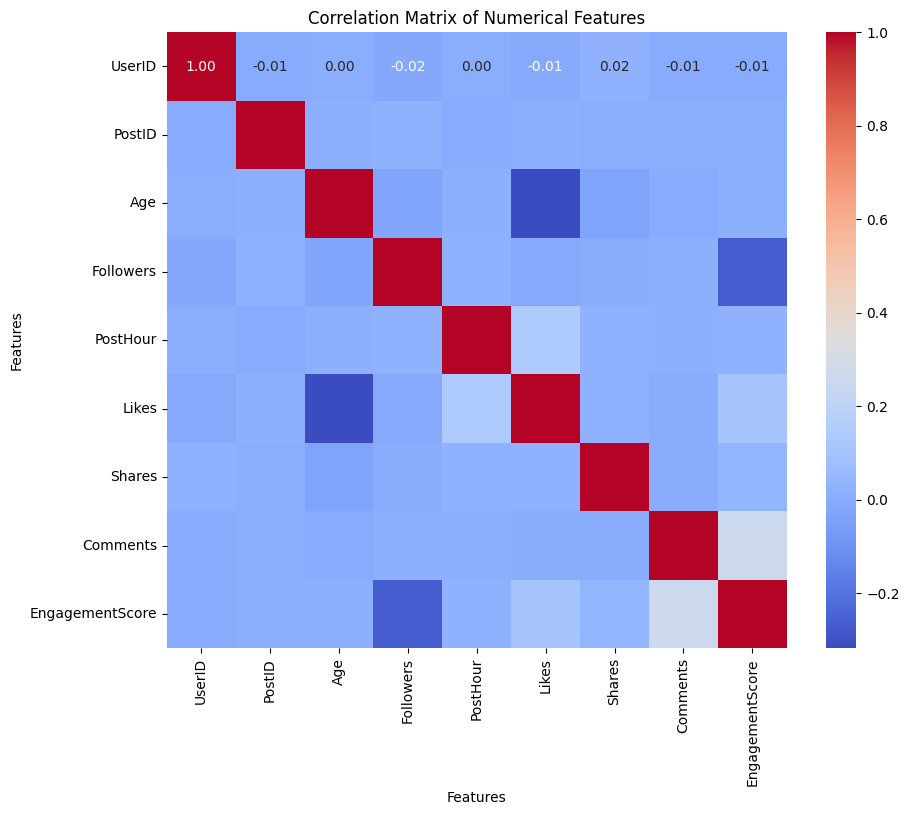

In [372]:
numerical_df = df.drop(categorical_features, axis=1)
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Matrix of Numerical Features')
plt.xlabel('Features')
plt.ylabel('Features')

plt.show()

# Feature engineering

In [214]:
categorical_features = ['PostType', 'Country', 'PostWeekday']
continuous_features = ['Age', 'Followers', 'Likes', 'Shares', 'Comments']
target = 'EngagementScore'

In [120]:
def calculate_aggregates(data, features):
    """Calculate aggregated features for each user"""
    user_stats = data.groupby('UserID')[features].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

    user_stats.columns = ['_'.join(col).strip() for col in user_stats.columns.values]
    user_stats.rename(columns={'UserID_': 'UserID'}, inplace=True)
    return user_stats

# Modelling

In [388]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, shuffle =True)

# train_user_stats = calculate_aggregates(train_df, continuous_features)
# test_user_stats = calculate_aggregates(test_df, continuous_features)

In [389]:
X_train = train_df.drop(['EngagementScore', 'UserID', 'PostID'], axis=1)
y_train = train_df['EngagementScore']
X_test = test_df.drop(['EngagementScore', 'UserID', 'PostID'], axis=1)
y_test = test_df['EngagementScore']

In [390]:
encoder = TargetEncoder(cols=categorical_features)

X_train_encoded = encoder.fit_transform(X_train, y_train)

X_test_encoded = encoder.transform(X_test)

In [391]:
X_train, X_test = X_train_encoded, X_test_encoded

In [392]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [393]:
ridge_reg = Ridge(alpha=1.0) 

ridge_reg.fit(X_train_scaled, y_train)

y_pred = ridge_reg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [394]:
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 8.737558318701664
R² Score: 0.20407092363758583


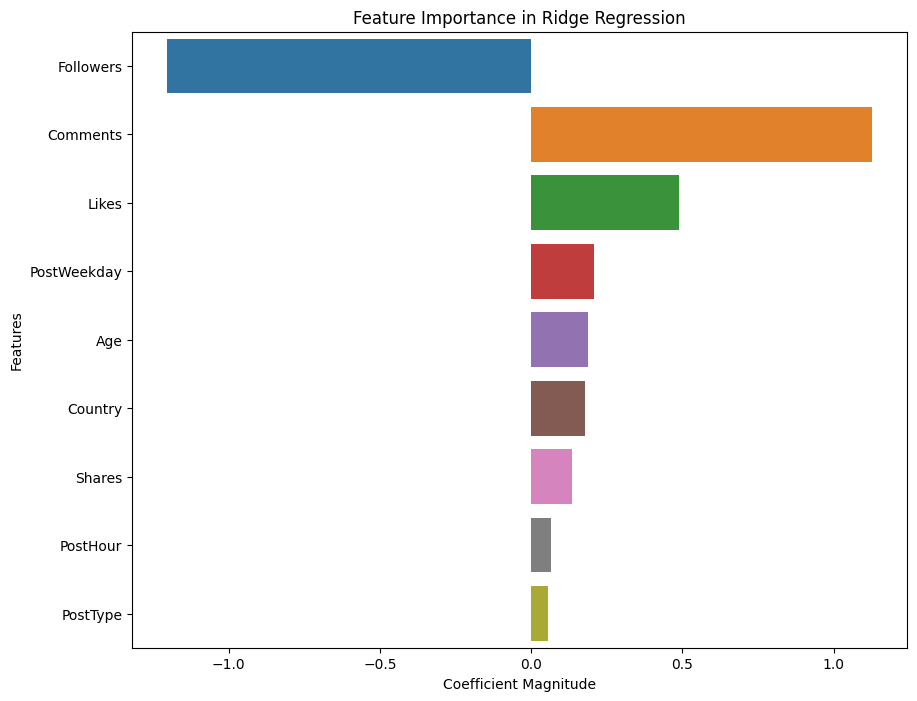

In [395]:
coefficients = ridge_reg.coef_

features = X_train.columns
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False).drop('abs_coefficient', axis=1)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature')
plt.title('Feature Importance in Ridge Regression')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.show()

In [ ]:
dt_regressor = DecisionTreeRegressor(random_state=42)

dt_regressor.fit(X_train_scaled, y_train)

y_pred = dt_regressor.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

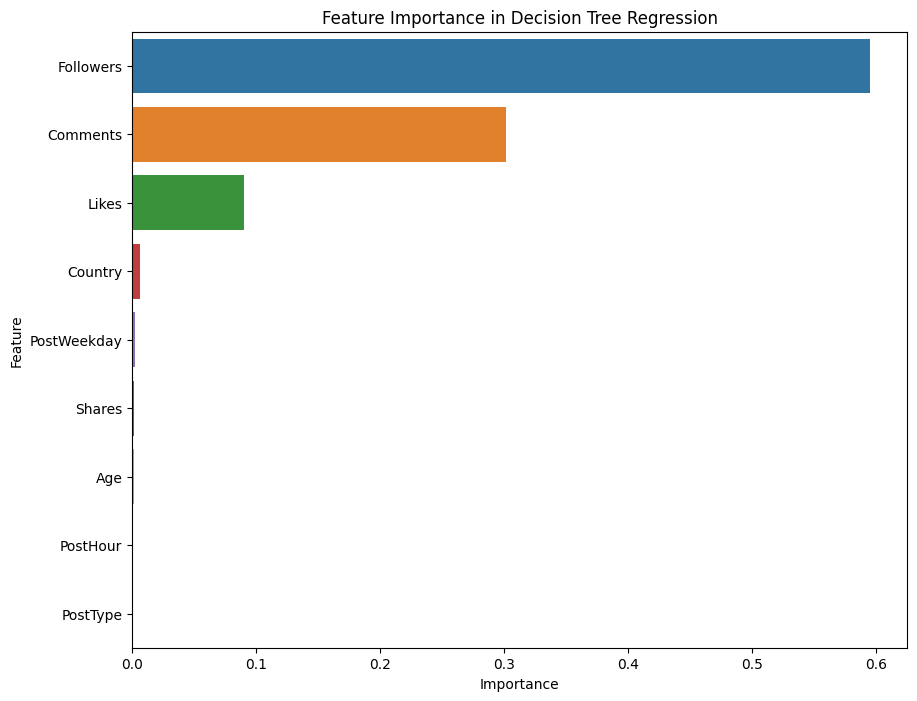

In [309]:
importances = dt_regressor.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance in Decision Tree Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [399]:
dt_regressor = DecisionTreeRegressor(random_state=42)

scores = cross_val_score(dt_regressor, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"Mean R² Score: {np.mean(scores)}")
print(f"Standard Deviation of R² Scores: {np.std(scores)}")

Mean R² Score: 0.6569347289006403
Standard Deviation of R² Scores: 0.4747321562387914


In [400]:
scores = cross_val_score(dt_regressor, X_train_scaled, y_train, cv=6, scoring='r2')

print(f"Mean R² Score: {np.mean(scores)}")
print(f"Standard Deviation of R² Scores: {np.std(scores)}")

Mean R² Score: 0.8883667885918539
Standard Deviation of R² Scores: 0.054710167934579904


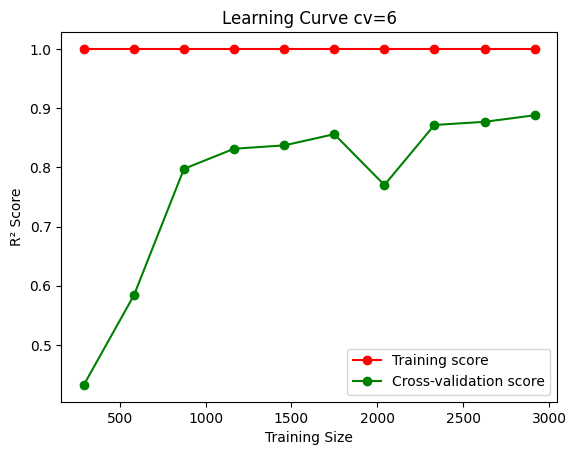

In [385]:
train_sizes, train_scores, validation_scores = learning_curve(
    DecisionTreeRegressor(random_state=42), X_train_scaled, y_train, cv=6,
    scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.title("Learning Curve cv=6")
plt.xlabel("Training Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.show()

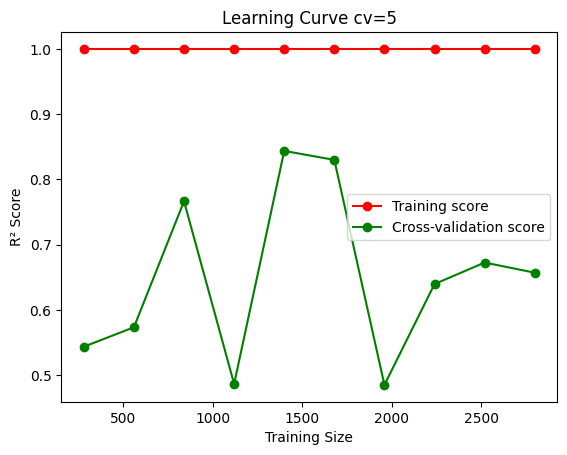

In [386]:
train_sizes, train_scores, validation_scores = learning_curve(
    DecisionTreeRegressor(random_state=42), X_train_scaled, y_train, cv=5,
    scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.title("Learning Curve cv=5")
plt.xlabel("Training Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.show()

In [267]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_regressor.feature_importances_
}).sort_values(by='importance', ascending=False)
print(feature_importance)

       feature  importance
2    Followers    0.606354
8     Comments    0.296999
6        Likes    0.054419
5  PostWeekday    0.026104
4     PostHour    0.008051
7       Shares    0.006758
0          Age    0.000577
3     PostType    0.000570
1      Country    0.000169


In [401]:
X_train

,Age,Country,Followers,PostType,PostHour,PostWeekday,Likes,Shares,Comments
1840,28,1.879115,702,1.324098,16,1.598493,17,4,3
2115,29,1.876544,56,1.830416,5,1.717183,22,3,53
4437,38,1.251027,552,1.830416,6,1.375392,17,4,51
1146,30,1.876544,27,1.667599,0,1.457100,20,6,1
2486,27,1.251027,247,1.667599,21,1.457100,23,3,1
...,...,...,...,...,...,...,...,...,...
4426,40,1.616779,436,1.324098,13,1.375392,13,5,54
466,44,1.273555,31,1.830416,16,1.457100,14,3,7
3092,30,1.876544,502,1.667599,19,1.375392,72,5,1
3772,46,1.251027,342,1.324098,18,1.557852,23,7,52


In [354]:
predictions = cross_val_predict(DecisionTreeRegressor(random_state=42), X_train_scaled, y_train, cv=5)

In [335]:
predictions.shape

(3500,)

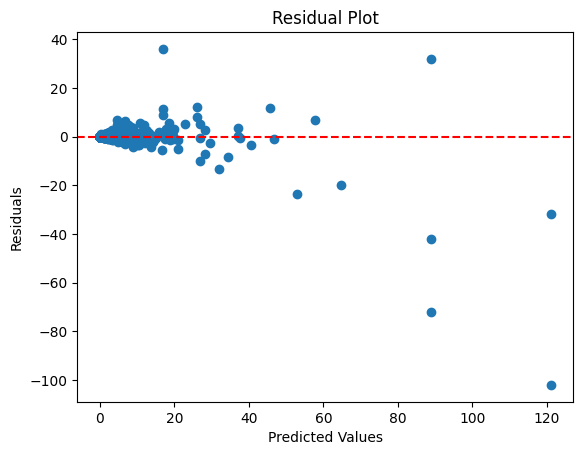

In [355]:
residuals = y_train - predictions

plt.scatter(predictions, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [268]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_features='sqrt')

rf_regressor.fit(X_train, y_train)

y_pred_rf = rf_regressor.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R² Score: {r2_rf}")

Random Forest Mean Squared Error: 0.45333938341374763
Random Forest R² Score: 0.9587040242184242


In [269]:
scores_rf = cross_val_score(rf_regressor, X_train, y_train, cv=5, scoring='r2')

print(f"Random Forest Cross-Validated R² Scores: {scores_rf.mean()} ± {scores_rf.std()}")

Random Forest Cross-Validated R² Scores: 0.8260979542436354 ± 0.08101041814755248
